In [1]:
# loading a few libraries ... 
import pylab as plt
import pandas as pd
import numpy as np
import swot_ssh_utils as swot
from cartopy import crs as ccrs
import xarray as xr
import sys as sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import datetime as dt
from netCDF4 import Dataset  # this is only needed if WW3OK > 0

from matplotlib.pyplot import cm
import pickle

WW3OK=2  # set to zero if you do not have the model output file. 2 for both REF102040 and NOREF runs


plt.rcParams.update({'font.size': 18,'savefig.facecolor':'white'})
cNorm = mcolors.Normalize(vmin=0, vmax=2)
jet = plt.get_cmap('jet')
mpl.rcParams.update({'figure.figsize':[14,6],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})


replacing spikes at ind: 0 SPOT-010248 [172 179] [0.6311906  0.50278108] [0.08216573 0.10504384]
replacing spikes at ind: 0 SPOT-010253 [ 43 113 123 223] [0.28884502 1.18895547 0.40695627 1.72142032] [0.12576769 0.18664571 0.16635042 0.49789969]
replacing spikes at ind: 0 SPOT-010289 [ 12  23 173 180] [0.21757619 0.3760222  0.49086865 0.78388487] [0.08217131 0.16652238 0.20886463 0.2532503 ]
replacing spikes at ind: 0 SPOT-010333 [ 87 160 164 171 197] [1.24440053 0.87003567 0.39944591 0.95876305 1.1104487 ] [0.49486771 0.17011606 0.15289546 0.24501372 0.4660034 ]
replacing spikes at ind: 0 SPOT-010338 [ 98 118 122 140] [0.90696703 0.85760352 0.66758224 0.60776988] [0.23043284 0.25623566 0.292887   0.17875548]
replacing spikes at ind: 0 SPOT-010351 [31] [0.4565316] [0.13805344]
replacing spikes at ind: 0 SPOT-010362 [20 32] [0.87415824 0.5112651 ] [0.21557649 0.19743847]
replacing spikes at ind: 0 SPOT-010365 [  2   6  17  84  89 104 117 158 162 198] [0.37596956 0.22971514 0.63203216 0.

/tmp/ipykernel_30747/3640466053.py:52: RuntimeWarning: divide by zero encountered in divide
  ind=np.where(H18[1:nt-2]**2/(H18[0:nt-3]*H18[2:nt-1]) > 5.)[0]


<Figure size 2000x1300 with 0 Axes>

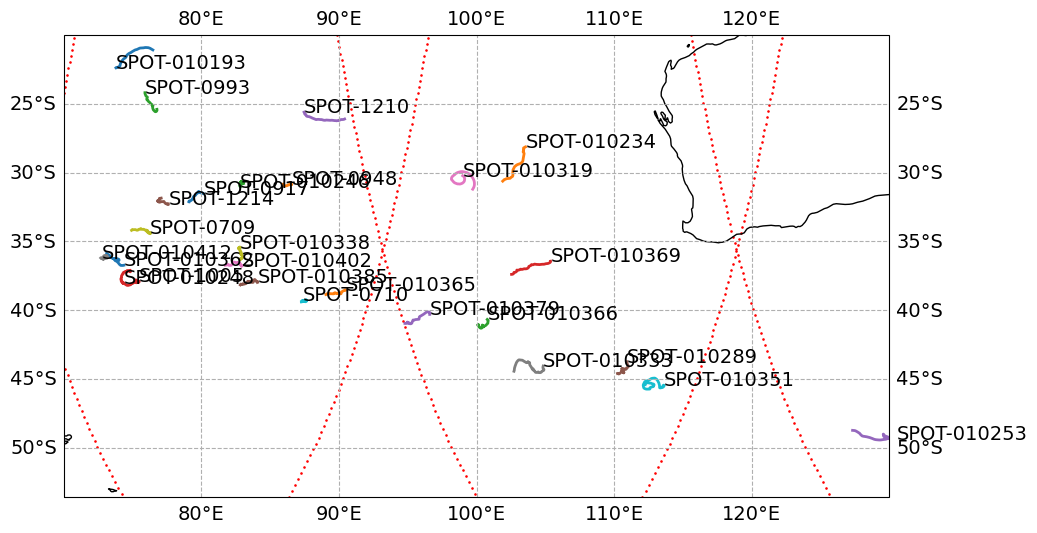

In [2]:
# loads spotter buoy data and makes a map
with open("06_06_2023_storm_spectra_with_direction_coefficients.pkl", 'rb') as handle:
    spotter_spectra = pickle.load(handle)
    
#allbuoys = list(spotter_spectra.keys());
# removed 010435 : too noisy
allbuoys = ['SPOT-010193', 'SPOT-010234', 'SPOT-010246', 'SPOT-010248', 'SPOT-010253', 'SPOT-010289', 'SPOT-010319', 'SPOT-010333', 'SPOT-010338', 'SPOT-010351', 'SPOT-010362', 'SPOT-010365', 'SPOT-010366', 'SPOT-010369', 'SPOT-010379', 'SPOT-010385', 'SPOT-010402', 'SPOT-010412',  'SPOT-0709', 'SPOT-0710', 'SPOT-0917', 'SPOT-0948', 'SPOT-0993', 'SPOT-1005', 'SPOT-1210', 'SPOT-1214']


nb=np.shape(allbuoys)[0]

plt.figure(figsize=(20,13))
(fig, ax) = plt.subplots(nrows=1, ncols=1, subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([70, 130, -50, -20])
ax.coastlines()
gl = ax.gridlines(draw_labels=True, linestyle="--", alpha = 1)
gl.bottom_labels = True
gl.left_labels= True


# finds length of records in time
ntMAX=0
for spotter_id in allbuoys:
    spot1 = spotter_spectra[spotter_id]
    plt.plot(spot1['longitude'], spot1['latitude'], lw=2)
    plt.text(spot1['longitude'][-1], spot1['latitude'][-1], spotter_id)
    nt=np.shape(spot1['time'])[0]
    if nt > ntMAX:
       ntMAX=nt
spottab2=np.zeros((nb,nt,5))
spottab1=np.zeros((nb,5))
ib=0
with open("cycle546.pkl", 'rb') as handle:
    lonlat = pickle.load(handle)
for ip in range(28):
  ax.scatter(lonlat[ip,0:1972:5,0],lonlat[ip,0:1972:5,1], c='r',marker='.',s=3) #, label='nadir')
fig.savefig('Spotter_map_with_tags.png',dpi=100)

# Computes H18: height for periods longer than 18s 
# this includes some spike clean-up
for spotter_id in allbuoys:
    spot1 = spotter_spectra[spotter_id]
    df= spot1['frequency'][1]-spot1['frequency'][0]
    dt=spot1['time'][1]-spot1['time'][0]
    nt=np.shape(spot1['time'])[0]
    spottab2[ib,0:nt,0]=spot1['longitude']
    spottab2[ib,0:nt,1]=spot1['latitude']
    spottab2[ib,0:nt,2]=spot1['time']
    H18=4*np.sqrt(np.sum(spot1['e'][0:nt,0:3],axis=1)*df)
    H18old=H18
    for step in range(2):
      ind=np.where(H18[1:nt-2]**2/(H18[0:nt-3]*H18[2:nt-1]) > 5.)[0]
      if len(ind) > 0:
          mid=0.5*(H18[ind]+H18[ind+2])
          print('replacing spikes at ind:',step,spotter_id,ind,H18[ind+1],mid)
          H18[ind+1]=mid
    #print('ind:',ind)
     
    spottab2[ib,0:nt,3]=H18
    #imax=np.where()                              
    imax = np.argmax(H18)
    spottab1[ib,0]=spot1['longitude'][imax]
    spottab1[ib,1]=spot1['latitude'][imax]
    spottab1[ib,2]=imax
    spottab1[ib,3]=np.max(H18)
    ib=ib+1

plt.show()


In [3]:
# Now we read some model output, is available
# Exemple of file read with E(f) data 

if (WW3OK > 0):
    path1='/media/ardhuin/FabLinux/WW3-SWOT/GLOBALGQM3/'
    fileef=path1+'SWOT_WW3-GLOB-30M_202306_ef.nc'
    nc_ww3 = Dataset(fileef,'r')
    ds_ww3 = xr.open_dataset(fileef)

    fw3=ds_ww3.f
    tw3=ds_ww3.time
    nf=np.size(fw3)
    dfw3=fw3*(1.1-1/1.1)*0.5

# We selct the days 6 to 12 ... and first 5 freq.  plus half of 6th 
    nt0=4*8
    ntw=12*8
    E3D = 0.5*dfw3[5]*(10**(ds_ww3.ef[nt0:ntw,5,:,:])-1E-12)+dfw3[4]*(10**(ds_ww3.ef[nt0:ntw,4,:,:])-1E-12)+dfw3[3]*(10**(ds_ww3.ef[nt0:ntw,3,:,:])-1E-12)+dfw3[2]*(10**(ds_ww3.ef[nt0:ntw,2,:,:])-1E-12)

    H3D=4*np.sqrt(E3D)
    H2D=np.max(H3D,axis=0)
    
if (WW3OK > 1):
    path1='/media/ardhuin/FabLinux/WW3-SWOT/GLOBAL_REF102040/'
    fileef=path1+'SWOT_WW3-GLOB-30M_202306_ef.nc'
    nc_ww3 = Dataset(fileef,'r')
    ds_ww3 = xr.open_dataset(fileef)

# We selct the dayss ... and first 5 freq.  plus half of 6th
    E3D_noref = 0.5*dfw3[5]*(10**(ds_ww3.ef[nt0:ntw,5,:,:])-1E-12)+dfw3[4]*(10**(ds_ww3.ef[nt0:ntw,4,:,:])-1E-12)+dfw3[3]*(10**(ds_ww3.ef[nt0:ntw,3,:,:])-1E-12)+dfw3[2]*(10**(ds_ww3.ef[nt0:ntw,2,:,:])-1E-12)
    H3D_noref=4*np.sqrt(E3D_noref)
    H2D_noref=np.max(H3D_noref,axis=0)

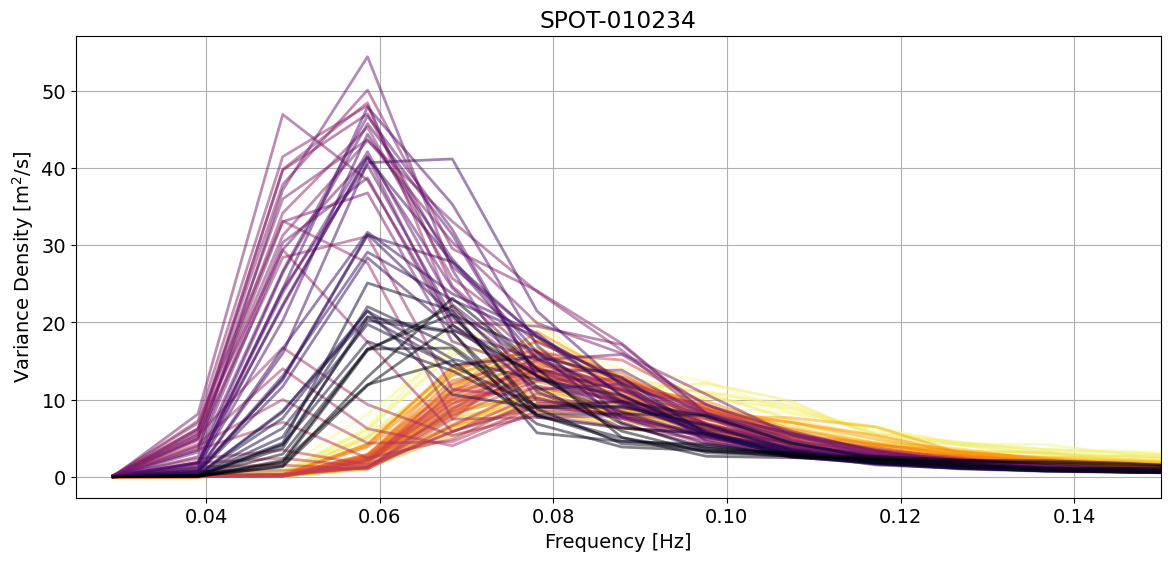

/tmp/ipykernel_30747/3477869423.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(labels)
/tmp/ipykernel_30747/3477869423.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs=plt.subplots(1,1,figsize=(9,3))


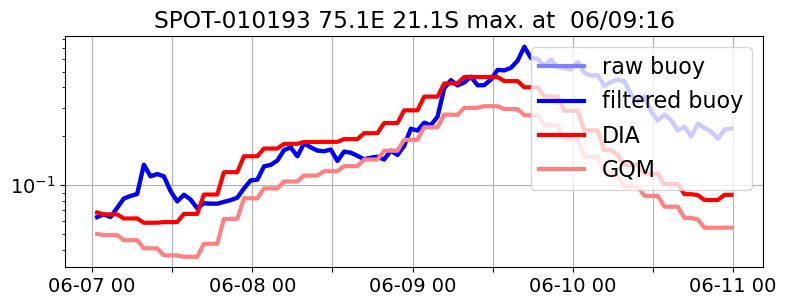

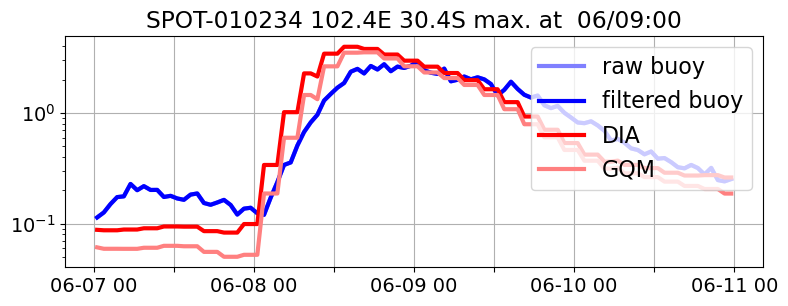

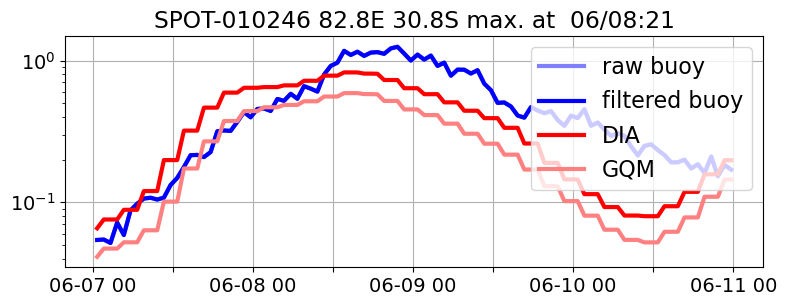

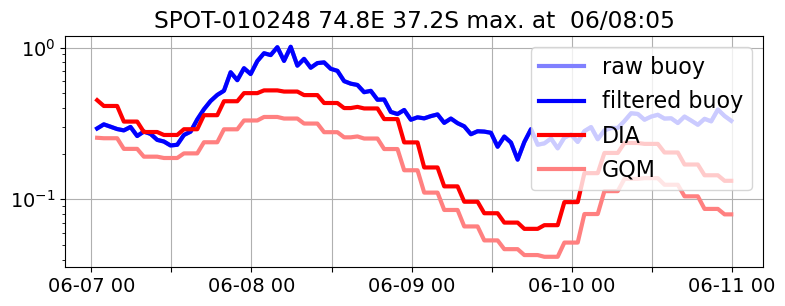

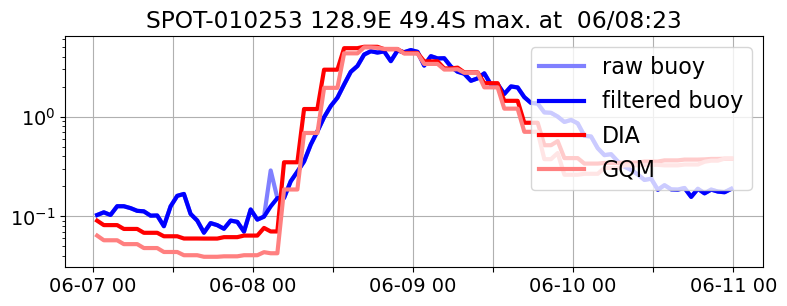

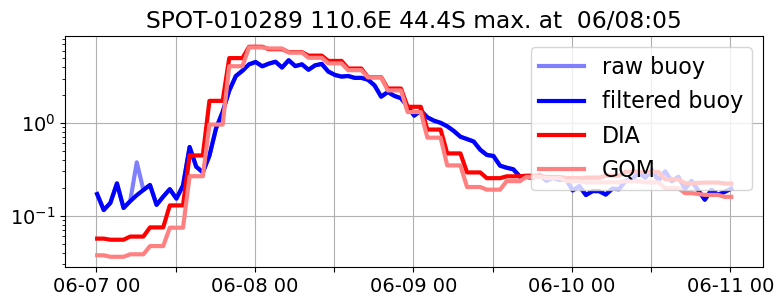

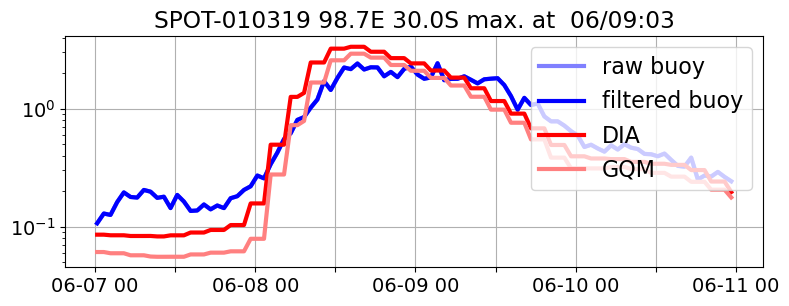

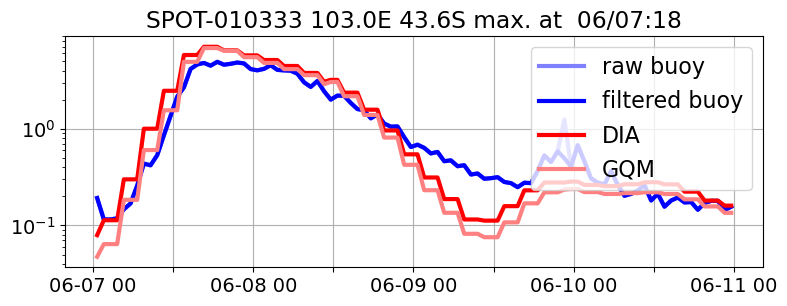

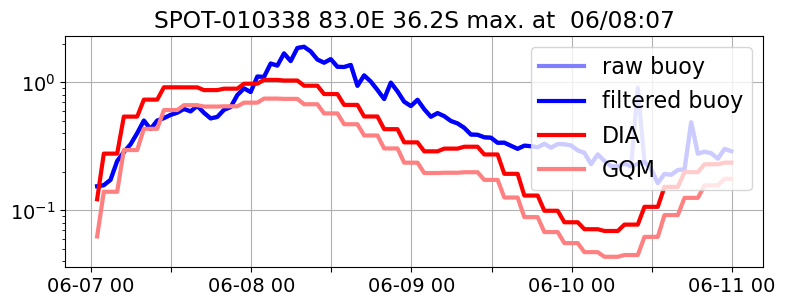

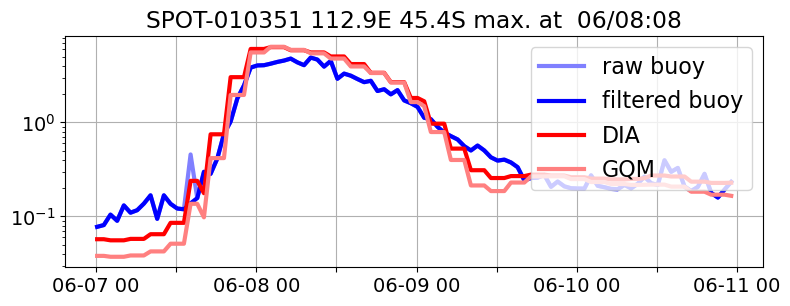

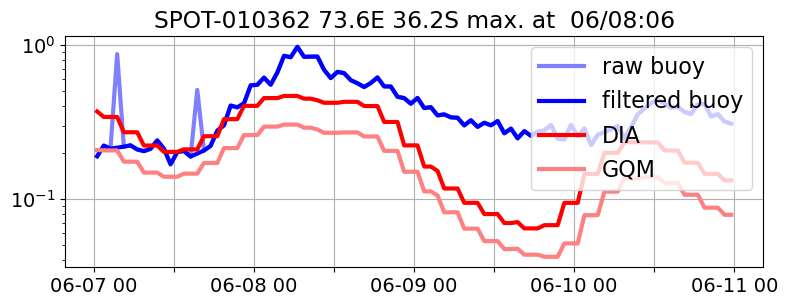

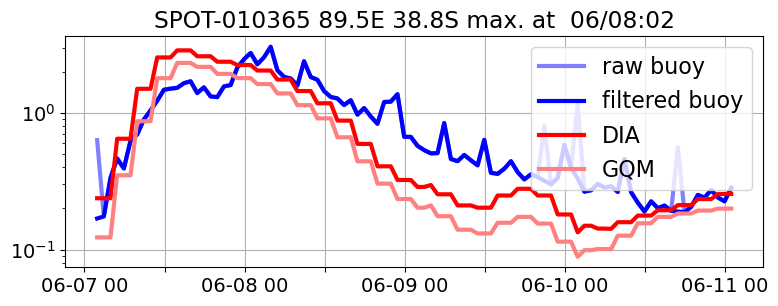

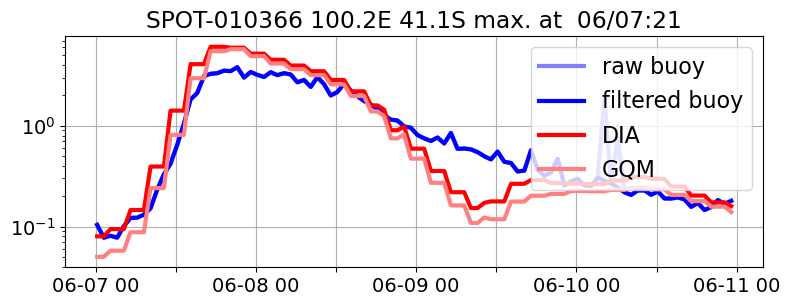

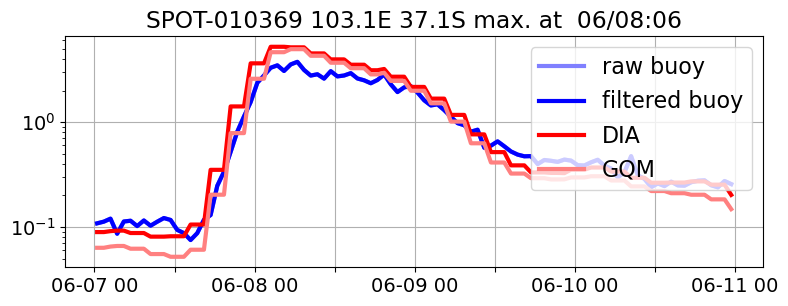

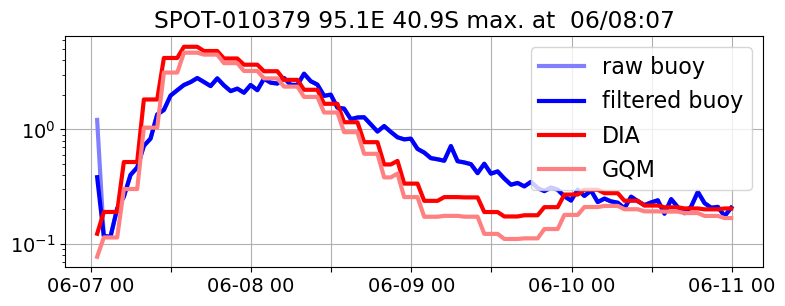

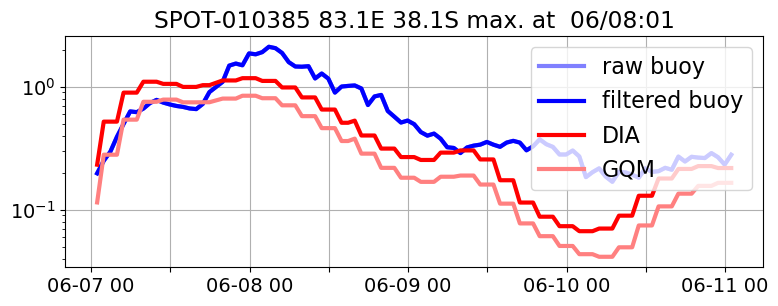

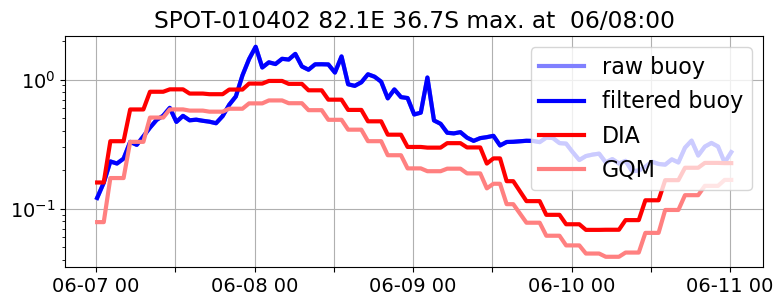

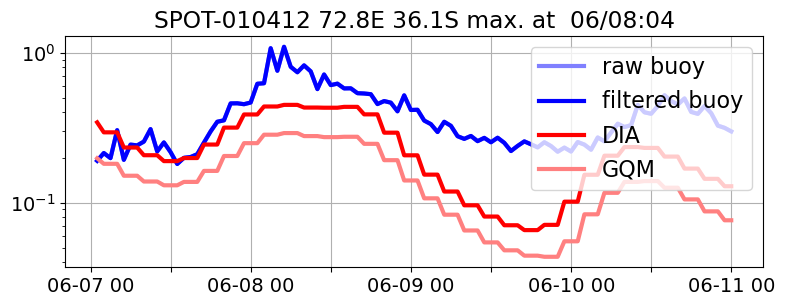

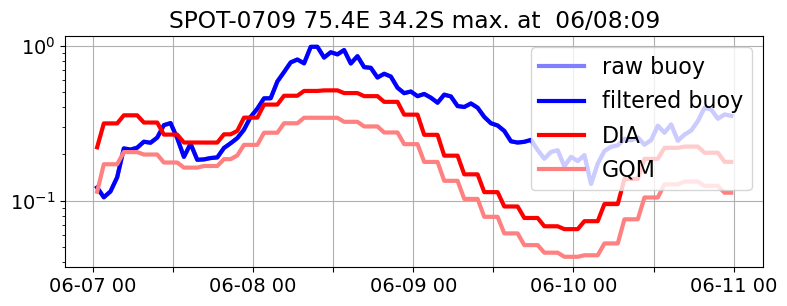

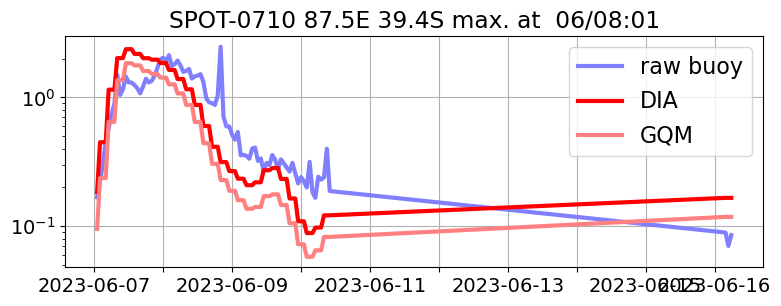

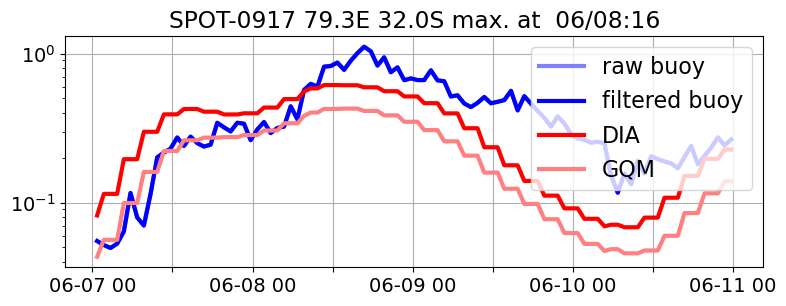

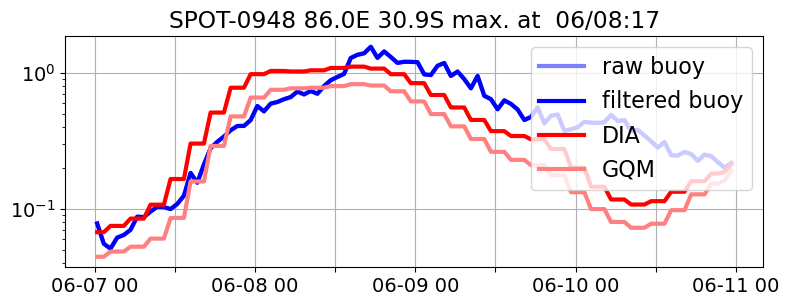

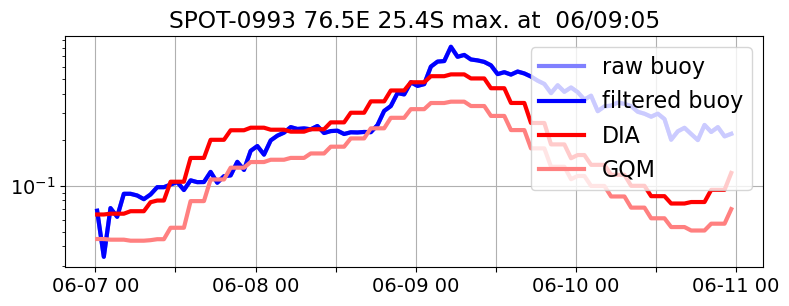

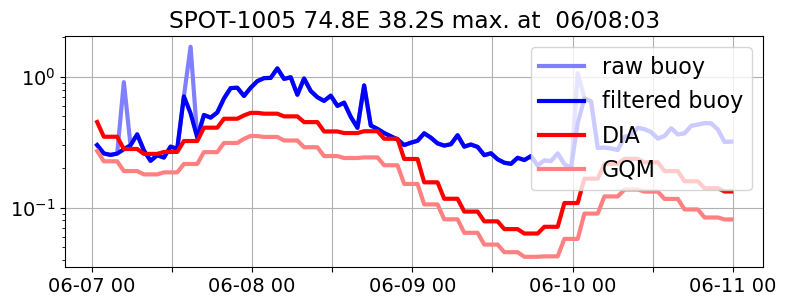

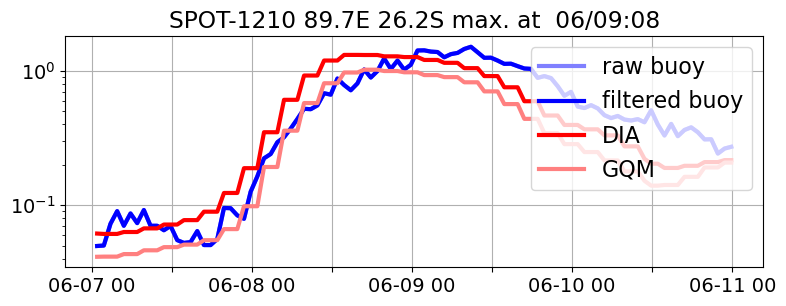

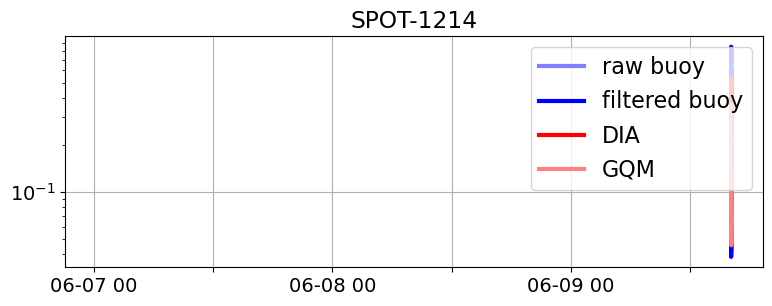

In [4]:

spotter_id = "SPOT-010234" # max 2.5

spot1 = spotter_spectra[spotter_id]
df= spot1['frequency'][1]-spot1['frequency'][0]
dt=spot1['time'][1]-spot1['time'][0]
nt=np.shape(spot1['time'])[0]
ntmax=100


#print('freq:',spot1['frequency'][0:5],' dt:',dt,'nt:',nt)
color_list = cm.inferno_r(np.linspace(0, 1, ntmax))


for ii, color in enumerate(color_list):
    plt.plot(spot1['frequency'], spot1['e'][ii,:],
             alpha=0.5, c=color, lw=2)
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Variance Density [m$^2$/s]')
plt.xlim(0.025, 0.15)
plt.title(spotter_id)
plt.show()

for ib in range(nb):
    spotter_id=allbuoys[ib]
    spotn = spotter_spectra[spotter_id]
    nt=np.shape(spot1['time'])[0]
    ntmax=114
    
    fig,axs=plt.subplots(1,1,figsize=(9,3))
    axs.plot(spotn['time'][18:ntmax], 4*np.sqrt(np.sum(spotn['e'][18:ntmax,0:3],axis=1)*df),lw=3,color=[0.5, 0.5, 1],label='raw buoy')
    if len(spotn['time'][18:ntmax])==len(spottab2[ib,18:ntmax,3]):
        axs.plot(spotn['time'][18:ntmax], spottab2[ib,18:ntmax,3],lw=3,color='blue',label='filtered buoy')
    axs.set_yscale('log')
    lob=xr.DataArray(spotn['longitude'])
    lab=xr.DataArray(spotn['latitude'])
    tib=xr.DataArray(spotn['time'])
    if (WW3OK > 0):
        H20_w2b = H3D.sel(longitude= lob, latitude= lab , time = tib, method = 'nearest')
        axs.plot(tib[18:114], H20_w2b[18:114],lw=3,color='red',label='DIA')
        leg = axs.legend(loc='upper right', fontsize=16)
    if (WW3OK > 1):
        H20_w2b = H3D_noref.sel(longitude= lob, latitude= lab , time = tib, method = 'nearest')
        axs.plot(tib[18:114], H20_w2b[18:114],lw=3,color=[1,0.5,0.5],label='GQM')
        leg = axs.legend(loc='upper right', fontsize=16)

    lons=  " {0:.1f}E".format(spottab1[ib,0])
    lats=  " {0:.1f}S".format(abs(spottab1[ib,1]))
    date_time = spot1['time'][int(spottab1[ib,2])]           
    d2=pd.to_datetime(date_time)
    tims=d2.strftime(' %m/%d:%H')
    axs.title.set_text(spotter_id+  lons+lats+' max. at '+tims)
    
    labels = [item.get_text() for item in axs.get_xticklabels()]
    labels[1] = '';labels[3] = '';labels[5] = '';labels[7] = '';
    axs.set_xticklabels(labels)
    leg = axs.legend(loc='upper right', fontsize=16)
    #fig.savefig('spotter_H18_time_series_'+spotter_id+'.pdf') #png',dpi=50)
    fig.savefig('spotter_H18_time_series_'+spotter_id+'.png',dpi=50)


plt.plot(spot1['longitude'], spot1['latitude'], lw=2)
#plt.yscale('log')
#plt.xscale('log')
#plt.xlabel('Frequency [Hz]')
#plt.ylabel('Variance Density [m$^2$/s]')fig3_map_DIA.pn
#plt.xlim(0, 0.5)
plt.title(spotter_id)
plt.show()

<Figure size 1800x1000 with 0 Axes>

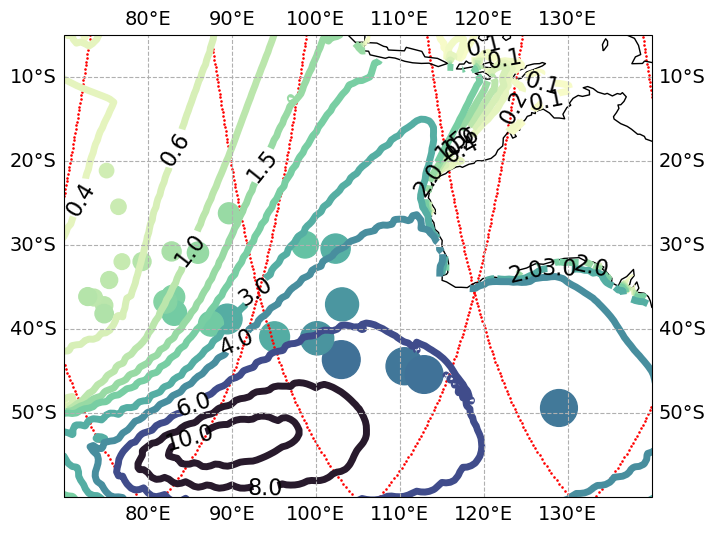

In [6]:
# Makes a map with the maximum values of H18 from spotter buoys.
import cmocean
import cmocean.cm as cmo
lightcmap = cmo.tools.lighten(cmo.deep, 2)

from matplotlib import colorbar, cm, pyplot
plt.figure(figsize=(18,10))
(fig, ax) = pyplot.subplots(nrows=1, ncols=1, subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([70, 140, -55, -5])
axs.title.set_text('Map of maximum vave height for periods T > 18 s')
ax.coastlines()
#ax.stock_img()
#plt.scatter(spottab1[:,0],spottab1[:,1],  marker='.', s = 100*spottab1[:,3])
norm = mcolors.Normalize( vmin = 0, vmax = 8)

plt.scatter(spottab1[:,0],spottab1[:,1], c=spottab1[:,3], s = 150*spottab1[:,3],norm=norm,cmap=lightcmap)
for ib in range(nb):
   H18s = "{0:.1f}".format(spottab1[ib,3])
   #plt.text(spottab1[ib,0]+1,spottab1[ib,1], str(H18s), fontsize=16)
    
# selects contour values 
if (WW3OK >0):
    conval=[0.1, 0.2, 0.4, 0.6, 1.0, 1.5, 2., 3., 4., 6., 8., 10]
    CS=plt.contour(ds_ww3.longitude, ds_ww3.latitude ,H2D,levels=conval,linewidths=5,norm=norm,cmap=lightcmap)
    fmt = r'%r'
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=16,colors='k')

gl = ax.gridlines(draw_labels=True, linestyle="--", alpha = 1)
gl.bottom_labels = True
gl.left_labels= True


with open("SWOT_tracks_cycle546.pkl", 'rb') as handle:
    lonlat = pickle.load(handle)
    
# Overlays SWOT tracks
for ip in range(28):
  ax.scatter(lonlat[ip,0:1972:5,0],lonlat[ip,0:1972:5,1], c='r',marker='.',s=3) #, label='nadir')

fig.savefig('fig3_map_GQM3.pdf')
fig.savefig('fig3_map_GQM3.png',dpi=100)